#### Table of Contents

1.   [Install Necessary Packages](#install)
2.   [Exploring Fake News](#fake)
3.   [Exploring Real News](#real)
4.   [Difference between Real and Fake News](#diff)
5.   [Real News Author Extraction](#author_real)
6.   [Mix Title and Text Column](#mix)
7.   [Splitting Data](#split)
8.   [Data Cleaning](#clean)
9.   [Word2Vectors Creation](#word2vec)
10.  [Model Creation](#model)
11.  [Load and Evaluate Model](#load_model)
12.  [Predicting New Data](#pred)

<a id="install"></a>
### Install Necessary Packages

In [2]:
!pip install -r requirements.txt

     |████████████████████████████████| 23.9 MB 95 kB/s 
     |████████████████████████████████| 14.5 MB 31 kB/s 
     |████████████████████████████████| 12.4 MB 198 kB/s 
     |████████████████████████████████| 10.5 MB 37.0 MB/s 
     |████████████████████████████████| 661 kB 52.1 MB/s 
     |████████████████████████████████| 6.7 MB 29.0 MB/s 
     |████████████████████████████████| 215 kB 74.5 MB/s 
     |████████████████████████████████| 516.2 MB 4.5 kB/s 
     |████████████████████████████████| 115 kB 67.5 MB/s 
     |████████████████████████████████| 364 kB 77.4 MB/s 
     |████████████████████████████████| 454 kB 62.5 MB/s 
     |████████████████████████████████| 3.0 MB 57.8 MB/s 
     |████████████████████████████████| 2.9 MB 12.8 MB/s 
     |████████████████████████████████| 321 kB 74.2 MB/s 
     |████████████████████████████████| 283 kB 66.4 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85449 sha256=663e9e4ea5a43e93528c

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<a id="fake"></a>
### Exploring Fake News

In [3]:
fake_df = pd.read_csv('https://raw.githubusercontent.com/AI-kartheek/AI-Fake-News-Detection-System/main/datasets/Fake.csv')
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
fake_df.shape

(23481, 4)

In [ ]:
fake_df.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

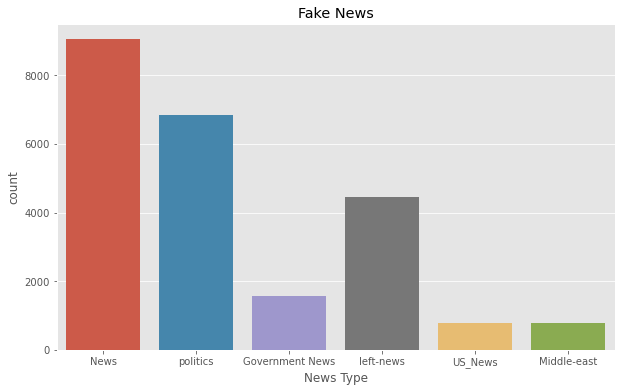

In [ ]:
plt.figure(figsize=(10, 6))
plt.style.use('ggplot')
sns.countplot(x='subject', data=fake_df)
plt.title('Fake News')
plt.xlabel('News Type')
plt.show()

In [ ]:
from wordcloud import WordCloud

In [ ]:
text = " ".join(fake_df.text.tolist())

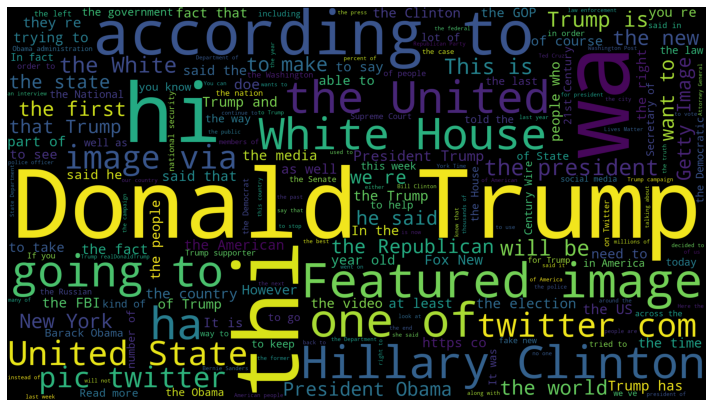

In [ ]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off') 
plt.show()

<a id="real"></a>
### Exploring Real News

In [4]:
real_df = pd.read_csv('https://raw.githubusercontent.com/AI-kartheek/AI-Fake-News-Detection-System/main/datasets/True.csv')
real_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
real_df.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

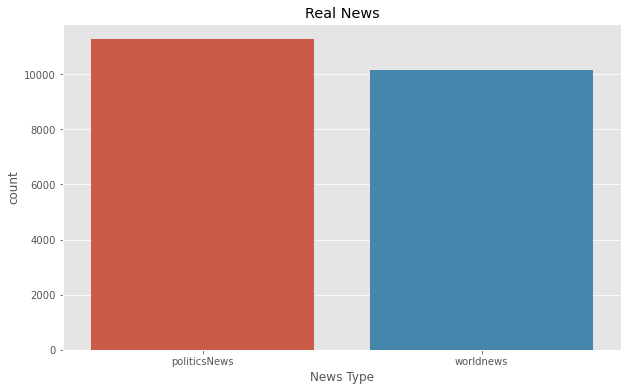

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='subject', data=real_df)
plt.title('Real News')
plt.xlabel('News Type')
plt.show()

In [ ]:
text = " ".join(real_df.text.tolist())

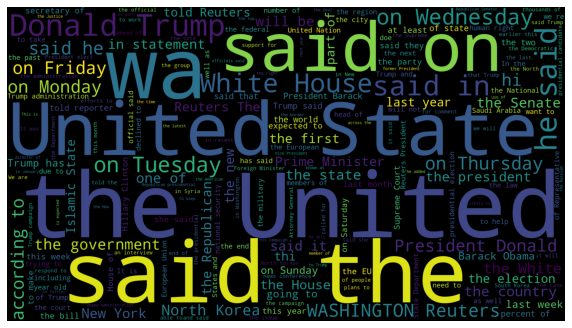

In [ ]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off') 
plt.show()

<a id="diff"></a>
### Difference between Real and Fake News
Real News seems to have source of publication which is not present in fake news.

By Looking at the data:
* most of ``Real text`` contains reuters information such as **WASHINGTON Reuters** and also mentioned exact week names such as Tuesday, Thursday, last Year, Monday etc.
* and also the ``Real news`` contains text from **twitter** and some of it doesn't contain any Publication Info.
* Here ``Fake News`` doesn't contain any publication info.

<a id="author_real"></a>
### Real News Author Extraction
* Unlike Real News data, Fake News doesn't contain any author overview. So we only perform author extraction on Real News only.

In [5]:
# to archieve maximum length(hyper parameter) of the publisher overview and its index

def getHyperParameter(df, max_length=1000):
    max_publisher_length=0
    max_publisher_index=0
    for i, val in enumerate(df.text.values):
        record = val.split('-', maxsplit=1)
        try:
            record[1] # raises an exception if the 1st index is not present
            length = len(record[0])
            if length < max_length:
                if max_publisher_length < length:
                    max_publisher_length = length
                    max_publisher_index = i
        except:
            pass
    return max_publisher_index, max_publisher_length


In [6]:
max_length=[1000, 986, 813, 747, 563, 545, 461, 452, 436, 371, 342, 259, 255, 242]
for length in max_length:
    max_publisher_index, max_publisher_length = getHyperParameter(real_df, length)
    print("For a Below max length of {}::".format(length))
    print("maximum sentence length = {}, and its index is {}. So the Text is ::\n text_1 => {}\n text_2 => {}".format(
                                                                            max_publisher_length, max_publisher_index,
                                                                            real_df.text[max_publisher_index].split('-')[0],
                                                                            real_df.text[max_publisher_index].split('-')[1]))
    print('==============================\n')

For a Below max length of 1000::
maximum sentence length = 986, and its index is 9009. So the Text is ::
 text_1 => Global health officials are racing to better understand the Zika virus behind a major outbreak that began in Brazil last year and has spread to many countries in the Americas.  The following are some questions and answers about the virus and current outbreak: How do people become infected? Zika is transmitted to people through the bite of infected female mosquitoes, primarily the Aedes aegypti mosquito, the same type that spreads dengue, chikungunya and yellow fever. The Pan American Health Organization (PAHO) said Aedes mosquitoes are found in all countries in the Americas except Canada and continental Chile, and the virus will likely reach all countries and territories of the region where Aedes mosquitoes are found. How do you treat Zika? There is no treatment or vaccine for Zika infection. Companies and scientists are racing to develop a safe and effective vaccine for 

* as we can see that After ``maximum sentence length = 255`` we don't have any publisher Names. And as the Publisher overview starts from below the ``maximum sentence length = 242``

* so our maximum sentence length to be choosen here is **255**

In [7]:
# collect unknown publishers(This may contain the empty text or null text)

unknown_publishers = []
for i,row in enumerate(real_df.text.values):
    try:
        record = row.split('-', maxsplit=1)
        
        # returns an exception if the list doesn't contain 1st index (this condition checks whether the data is splitted or not)
        record[1]
        assert(len(record[0]) < 255) # here 255 is the hyper parameter that we selected for maximum author length.
    except:
        unknown_publishers.append(i)

In [8]:
len(unknown_publishers)

112

In [9]:
real_df.iloc[unknown_publishers].head()

,title,text,subject,date
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
12,Factbox: Trump on Twitter (Dec 28) - Vanity Fa...,The following statements were posted to the ve...,politicsNews,"December 28, 2017"
13,"Trump on Twitter (Dec 27) - Trump, Iraq, Syria",The following statements were posted to the ve...,politicsNews,"December 28, 2017"
17,"Trump on Twitter (Dec 26) - Hillary Clinton, T...",The following statements were posted to the ve...,politicsNews,"December 26, 2017"


**check for Empty text column in Real News**

In [10]:
def CheckEmptyText(df, column):
    return [index for index, text in enumerate(df[column].values) if str(text).strip() == '']

In [11]:
## check for text column of unknown publishers is empty or not

empty_real_index = CheckEmptyText(real_df, 'text')
real_df.iloc[unknown_publishers].loc[empty_real_index] # just a single record is empty here

,title,text,subject,date
8970,Graphic: Supreme Court roundup,,politicsNews,"June 16, 2016"


* as we have a single row, we can directly drop it.

In [12]:
real_df.text[8970] # we cna see that it contains only a space character, so remove this one. 

' '

In [13]:
# dropping the empty record

real_df.drop(8970, axis=0, inplace=True)

In [14]:
## check for title column of unknown publishers is empty or not

empty_real_index = CheckEmptyText(real_df, 'title')
real_df.iloc[unknown_publishers].loc[empty_real_index]

,title,text,subject,date


**Make a separate column for publisher**

In [15]:
# collect the publisher and his text data

publisher= []
tmp_text = []

for index, row in enumerate(real_df.text.values):
    if index in unknown_publishers:
        publisher.append('Unknown')
        tmp_text.append(row)
    else:
        record = row.split('-', maxsplit=1)
        publisher.append(record[0].strip())
        tmp_text.append(record[1].strip())
        

In [16]:
## assign the list values
real_df['publisher'] = publisher
real_df['text'] = tmp_text

In [17]:
real_df.head() # we can see that another column is created here

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [18]:
real_df.shape

(21416, 5)

**Check Empty Text column in Fake News**

In [19]:
fake_df.shape

(23481, 4)

In [20]:
# extract the index for empty text for a fake news 
empty_fake_index = CheckEmptyText(fake_df, 'text')

In [21]:
print(fake_df.iloc[empty_fake_index].shape)
fake_df.iloc[empty_fake_index].head()

(630, 4)


,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"


* 630 That's a huge number we got, so we are not going to remove these data points.

In [22]:
# extract the index for empty title for a fake news 

empty_fake_index = CheckEmptyText(fake_df, 'title')
print(fake_df.iloc[empty_fake_index].shape)
fake_df.iloc[empty_fake_index].head()

(0, 4)


,title,text,subject,date


<a id="mix"></a>
### Mix Title and Text Column

In [23]:
def MixTitleText(df):
    return df['title'] + " "+ df['text']

In [24]:
real_df['text'] = MixTitleText(real_df)
fake_df['text'] = MixTitleText(fake_df)

<a id="split"></a>
### Splitting Data
* class = **0** for **Real News**
* class = **1** for **Fake News**

In [25]:
real_df['class'] = 0
fake_df['class'] = 1

In [26]:
real_df.head()

,title,text,subject,date,publisher,class
0,"As U.S. budget fight looms, Republicans flip t...","As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",WASHINGTON (Reuters),0
1,U.S. military to accept transgender recruits o...,U.S. military to accept transgender recruits o...,politicsNews,"December 29, 2017",WASHINGTON (Reuters),0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,Senior U.S. Republican senator: 'Let Mr. Muell...,politicsNews,"December 31, 2017",WASHINGTON (Reuters),0
3,FBI Russia probe helped by Australian diplomat...,FBI Russia probe helped by Australian diplomat...,politicsNews,"December 30, 2017",WASHINGTON (Reuters),0
4,Trump wants Postal Service to charge 'much mor...,Trump wants Postal Service to charge 'much mor...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters),0


In [27]:
# collect real and fake data
real_data = real_df[['text', 'class']]
fake_data = fake_df[['text', 'class']]

data = real_data.append(fake_data, ignore_index=True)

In [28]:
data.head()

,text,class
0,"As U.S. budget fight looms, Republicans flip t...",0
1,U.S. military to accept transgender recruits o...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,0
3,FBI Russia probe helped by Australian diplomat...,0
4,Trump wants Postal Service to charge 'much mor...,0


In [29]:
data.tail()

,text,class
44892,McPain: John McCain Furious That Iran Treated ...,1
44893,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,1
44894,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,1
44895,How to Blow $700 Million: Al Jazeera America F...,1
44896,10 U.S. Navy Sailors Held by Iranian Military ...,1


In [30]:
data.shape

(44897, 2)

In [31]:
def TrainTestSplit(data):
    df = data.copy() # copy the data so that there is no change in the previous object.
    
    filt = df['class'] == 0
    Test_0 = df.loc[filt].sample(2000, random_state=0)
    
    filt = df['class'] == 1
    Test_1 = df.loc[filt].sample(2000, random_state=0)
    
    Test_data = Test_0.append(Test_1, ignore_index=True)
    Train_data = df.drop(Test_data.index, axis=0)
    
    return Train_data.sample(Train_data.shape[0], random_state=0), Test_data.sample(Test_data.shape[0], random_state=0)

In [32]:
Train_data, Test_data = TrainTestSplit(data)

In [33]:
Train_data.head()

,text,class
5801,Nearly half of Britons back Trump state visit:...,0
35218,BEST EVER CROOKED HILLARY Collection Of Lies A...,1
10573,South Dakota governor vetoes transgender bathr...,0
10253,McConnell rules out action this year on high c...,0
41240,WOW! DID “Open Borders” Paul Ryan’s Top Adviso...,1


In [34]:
Train_data['class'].value_counts()

1    23481
0    17416
Name: class, dtype: int64

In [35]:
Test_data['class'].value_counts()

1    2000
0    2000
Name: class, dtype: int64

<a id="clean"></a>
### Data Cleaning

In [36]:
import contractions as cont # to fix the contractions we use this library

print(cont.fix("u"))
print(cont.fix("i'd"))
print(cont.fix("we'll've"))

you
I would
we will have


In [37]:
from bs4 import BeautifulSoup
import re
import unicodedata
import contractions as cont # to fix the contractions we use this library

def DataCleaner(x):
    x = BeautifulSoup(x, 'html.parser').get_text() # remove html tags
    x = re.sub(r'(http|ftp|https)\S+\s*', '', x)  # remove URLs
    x = re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', '', x) # remove Emails
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore') # remove Accented Text
    x = " ".join([cont.fix(word.lower()) for word in x.split()]) # we expand the contraction of words
    x = re.sub('[^a-zA-Z0-9]+', ' ', x) # here we replace all with a space character except for Alpha numericals.
    x = x.lower()
    
    # removing unwanted words that has a text length of 1 like 't', 's' etc
    useful_chars = ['a', 'i', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    x = " ".join([word for word in x.split() if len(word) != 1 or word in useful_chars])
    
    # correct some words like 're' to 'are' etc
    correct = {'re' : 'are', 'couldn' : 'could not'}
    x = " ".join([correct[word] if word in correct.keys() else word for word in x.split()])

    return x


**clean Train Data**

In [38]:
%%time
Train_data['text'] = Train_data['text'].apply(lambda x: DataCleaner(x))
Train_data.head()

CPU times: user 1min 10s, sys: 321 ms, total: 1min 11s
Wall time: 1min 11s


**clean Test Data**

In [40]:
%%time
Test_data['text'] = Test_data['text'].apply(lambda x: DataCleaner(x))
Test_data.head()

CPU times: user 7.39 s, sys: 53.9 ms, total: 7.44 s
Wall time: 7.44 s


In [41]:
Train_data.text.iloc[0]

'nearly half of britons back trump state visit yougov poll around half of britons believe you president donald trumps planned uk state visit should go ahead even though a similar number would not like to see his controversial migrant ban implemented in britain according to a poll on wednesday trumps executive order to temporarily ban refugees entering the united states and limit migration from seven muslim majority countries has drawn widespread protest in britain and nearly 1 8 million people have signed a petition to stop his state visit planned for later this year but the yougov poll found 49 percent of britons believe the state visit should go ahead and that only 36 percent want it to be canceled a state visit would involve lavish displays of royal pageantry and a banquet hosted by queen elizabeth the invitation was conveyed by prime minister theresa may when she visited washington last week just hours before the travel ban was introduced britons would not like to see a similar mig

<a id="word2vec"></a>
### Word2Vectors Creation

In [42]:
import gensim

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [43]:
# get the x and y values for train data

y_train = Train_data['class'].values
x_train = [sent.split() for sent in Train_data['text'].tolist()]

In [44]:
# get the x and y values for test data

y_test = Test_data['class'].values
x_test = [sent.split() for sent in Test_data['text'].tolist()]

In [45]:
%%time
vec_size= 100 # make each word to a vector of 100 dimensions

# window=10 means ngrams=10 ie 10 consecutive words to be taken into consideration to get a vector of each word.
# min_count=1 means we want to generate a vector if we also have a single word
w2v_model = gensim.models.Word2Vec(sentences= x_train, vector_size=vec_size, window=10, min_count=1)

CPU times: user 4min 8s, sys: 1.07 s, total: 4min 9s
Wall time: 2min 11s


In [46]:
print("we had got total of {} word to vectors.".format(w2v_model.wv.__len__()))

we had got total of 117089 word to vectors.


In [47]:
#w2v_model.wv.key_to_index

In [48]:
w2v_model.wv.get_vector('trump')

array([ 1.5468986 , -2.5376434 ,  2.262644  ,  0.51213264,  3.2169807 ,
        1.724024  , -0.44542667, -0.64427555,  4.978615  ,  1.4042556 ,
       -1.5548543 , -2.60616   , -3.0752873 ,  1.1066085 ,  0.82004166,
       -1.6338763 ,  2.6256974 , -1.1456138 ,  4.1500893 , -2.5260015 ,
       -0.587879  ,  2.887669  , -3.877178  ,  4.8838167 , -0.65529203,
        1.6525444 , -4.320244  ,  6.4872937 , -0.28683546, -0.98761094,
       -2.3698943 , -0.7445454 , -0.16969658,  1.3890797 ,  0.39325052,
       -1.2931658 , -3.126473  , -3.002089  ,  1.1767735 ,  0.41902307,
       -3.4854908 ,  3.3530028 , -0.28601387,  0.7817887 , -5.0277305 ,
       -1.0603456 ,  1.4543375 , -0.03258251, -3.0438218 ,  2.5399914 ,
        3.5849574 , -2.1922886 ,  0.69063425, -3.0937295 ,  1.2537497 ,
       -3.3739266 , -1.5660471 , -0.23168601,  4.3450074 ,  4.188537  ,
       -4.8009057 , -0.22576772, -4.5859704 , -1.2081051 , -3.1114173 ,
        1.753026  , -0.6850738 ,  0.6063394 , -0.25938317, -3.55

In [49]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [50]:
# convert texts to sequences on train data

x_train_seq = tokenizer.texts_to_sequences(x_train)

In [51]:
# convert texts to sequences on test data

x_test_seq = tokenizer.texts_to_sequences(x_test)

In [52]:
vocab_size = len(tokenizer.index_word) +1
vocab_size

117090

In [53]:
# get the max senence length and it's index

max_sent_len = 0
max_sent_ind = 0
for i,sent in enumerate(x_train_seq):
    if max_sent_len < len(sent):
        max_sent_len = len(sent)
        max_sent_ind = i
print("maximum sentence length = {} and its index= {}".format(max_sent_len, max_sent_ind))

maximum sentence length = 8229 and its index= 10701


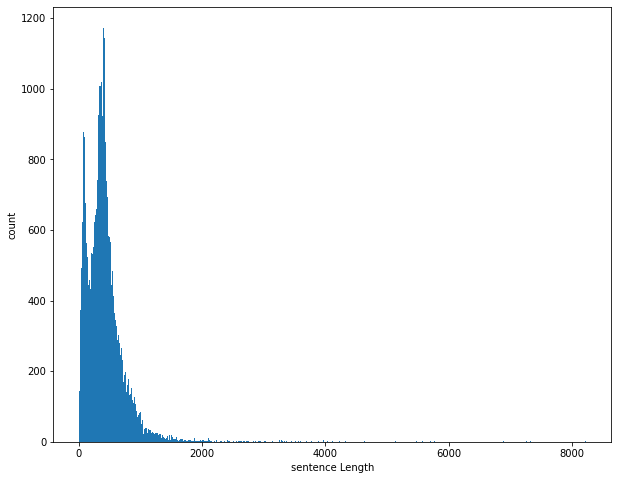

In [ ]:
plt.figure(figsize=(10,8))
plt.hist([len(x) for x in x_train_seq], bins=700)
plt.xlabel('sentence Length')
plt.ylabel('count')
plt.show()

* we observe that most of the sentence length are fallen below 1000, it's better to **truncate** all sentences to **1000** length

In [54]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [55]:
maxlen = 1000

# pad on train sequences
x_train_pad_seq = pad_sequences(x_train_seq, maxlen=maxlen)

In [56]:
# pad on test sequences
x_test_pad_seq = pad_sequences(x_test_seq, maxlen=maxlen)

In [57]:
# function for loading vectors weights for each word

def get_weight_matrix(model):
    weight_matrix = np.zeros((vocab_size, vec_size))
    for word, i in tokenizer.word_index.items():
        weight_matrix[i] = model.wv.get_vector(word)
    return weight_matrix

In [58]:
embedding_vectors = get_weight_matrix(w2v_model)

In [59]:
embedding_vectors.shape

(117090, 100)

<a id="model"></a>
### Model Creation

In [60]:
import tensorflow as tf
print(tf.__version__)

## we set the seed so that we receive the same random weights at each time we train the program
tf.random.set_seed(1)

2.2.0


In [ ]:
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, vec_size, weights=[embedding_vectors], input_length = maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         11709000  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 11,826,377
Trainable params: 117,377
Non-trainable params: 11,709,000
_________________________________________________________________


In [ ]:
y_train.shape[0]/4

10224.25

In [ ]:
# implementing early stopping and model check point 

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# stop training process if the accuracy of the train data is not decreased after 5 epochs
es = EarlyStopping(monitor= "accuracy" , min_delta= 0, patience= 5, mode='max', verbose=1)

# do not save the weights until and unless the validation accuracy is not increased.
mc = ModelCheckpoint(filepath= "Fake News Detection using LSTMs.h5",
                     monitor="val_accuracy", verbose=1, save_best_only= True)

In [ ]:
model.fit(x_train_pad_seq, y_train, validation_data=(x_test_pad_seq, y_test), batch_size=4, epochs=20, callbacks=[es,mc])

Epoch 1/20
10225/10225 [==============================] - ETA: 0s - loss: 0.0821 - accuracy: 0.9714
Epoch 00001: val_accuracy improved from -inf to 0.98725, saving model to Fake News Detection using LSTMs.h5
10225/10225 [==============================] - 324s 32ms/step - loss: 0.0821 - accuracy: 0.9714 - val_loss: 0.0373 - val_accuracy: 0.9872
Epoch 2/20
10225/10225 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.9898
Epoch 00002: val_accuracy improved from 0.98725 to 0.99350, saving model to Fake News Detection using LSTMs.h5
10225/10225 [==============================] - 323s 32ms/step - loss: 0.0309 - accuracy: 0.9898 - val_loss: 0.0247 - val_accuracy: 0.9935
Epoch 3/20
10224/10225 [============================>.] - ETA: 0s - loss: 0.0250 - accuracy: 0.9922
Epoch 00003: val_accuracy did not improve from 0.99350
10225/10225 [==============================] - 324s 32ms/step - loss: 0.0250 - accuracy: 0.9922 - val_loss: 0.1319 - val_accuracy: 0.9467
Epoch 4/20
1

<a id="load_model"></a>
### Load and Evaluate Model

In [67]:
from tensorflow.keras.models import load_model
Model = load_model('saved models/Fake News Detection using LSTMs.h5')

In [62]:
## evaluation on train data

Model.evaluate(x_train_pad_seq, y_train, batch_size=1)

40897/40897 [==============================] - 433s 11ms/step - loss: 0.0042 - accuracy: 0.9987


[0.004191009793430567, 0.9987040758132935]

In [63]:
## evaluation on test data

Model.evaluate(x_test_pad_seq, y_test, batch_size=1)

4000/4000 [==============================] - 43s 11ms/step - loss: 0.0019 - accuracy: 0.9998


[0.001918923924677074, 0.999750018119812]

In [66]:
from sklearn.metrics import confusion_matrix, classification_report

def MetricEvaluation(x_data, y_data):
    y_pred = (Model.predict(x_data) > 0.5).astype('int')
    print("Confusion Matrix::\n{}\n\nClassification Report::\n{}".format(confusion_matrix(y_data, y_pred),
                                                                       classification_report(y_data, y_pred)))

In [67]:
# Metric Evaluation for Train Data

MetricEvaluation(x_train_pad_seq, y_train)

Confusion Matrix::
[[17388    28]
 [   25 23456]]

Classification Report::
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17416
           1       1.00      1.00      1.00     23481

    accuracy                           1.00     40897
   macro avg       1.00      1.00      1.00     40897
weighted avg       1.00      1.00      1.00     40897



In [68]:
# Metric Evaluation for Test Data

MetricEvaluation(x_test_pad_seq, y_test)

Confusion Matrix::
[[1999    1]
 [   0 2000]]

Classification Report::
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      1.00      1.00      2000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



<a id="pred"></a>
### Predicting New Data
* **Fake = 1**
* **Real = 0**

In [71]:
def getPrediction(x):
    x = DataCleaner(x)
    x = tokenizer.texts_to_sequences([x])
    x = pad_sequences(x, maxlen= maxlen)
    output = Model.predict(x) > 0.5
    if output:
        return "Fake"
    else:
        return "Real"

In [71]:
# example for fake sentence (Just given some random text manually)

text = "I provided some text here"
print("This sentence is {}.".format(getPrediction(text)))

This sentence is Fake.


In [72]:
# example for Real sentence (Data collected from online Resources)

text = "On Tuesday, Sir Patrick Vallance, the UK's Chief Scientific Officer, posted a correction about a statistic he had referred to during a press conference the day before."
print("This sentence is {}.".format(getPrediction(text)))

This sentence is Real.
